# Attention-Based Image Captioning

Attention-based image captioning is a deep learning technique where the model generates descriptive captions for images by focusing on specific regions of the image while generating each word of the caption. The attention mechanism allows the model to "attend" to relevant parts of the image for better caption accuracy, enhancing interpretability and effectiveness.

Dataset Used :[Fliker 30k image ](http://)https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset


# Key Applications
1. Image Captioning for Accessibility: Helping visually impaired individuals understand image content.
2. Content Creation: Automatically generating descriptive metadata for media.
3. Search and Retrieval: Enhancing image search engines by associating captions with images.

**Importing required libraries**

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O ,data manipulation

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

import json
import random
from PIL import Image
from sklearn.model_selection import train_test_split

version_fn = getattr(tf.keras, "version", None)
if version_fn and version_fn().startswith("3."):
  import tf_keras as keras
else:
  keras = tf.keras

import warnings
warnings.filterwarnings("ignore")
from collections import Counter
from tokenizers import BertWordPieceTokenizer
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
! pip install transformers

# Importing and Preparing data

In [3]:
#Images folder path
IMAGES_PATH = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images"
#Caption CSV file path
CAPTIONS_PATH = "/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv"
#approx unique words in vocab
vocab_length=25000

In [4]:
df = pd.read_csv(CAPTIONS_PATH, on_bad_lines='skip', sep = "|")
df = df.dropna()
df.columns = df.columns.str.strip()

In [5]:
df["image_path"] = df["image_name"].apply(lambda x: os.path.join(IMAGES_PATH,x))
df["preprocessed_comments"] = df["comment"].apply(lambda x: "[START] "+x.lower().replace('[^\w\s]','')+" [END]")

In [6]:
df.head()

,image_name,comment_number,comment,image_path,preprocessed_comments
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...,/kaggle/input/flickr-image-dataset/flickr30k_i...,[START] two young guys with shaggy hair look ...
1,1000092795.jpg,1,"Two young , White males are outside near many...",/kaggle/input/flickr-image-dataset/flickr30k_i...,"[START] two young , white males are outside n..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,/kaggle/input/flickr-image-dataset/flickr30k_i...,[START] two men in green shirts are standing ...
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,/kaggle/input/flickr-image-dataset/flickr30k_i...,[START] a man in a blue shirt standing in a g...
4,1000092795.jpg,4,Two friends enjoy time spent together .,/kaggle/input/flickr-image-dataset/flickr30k_i...,[START] two friends enjoy time spent together...


In [7]:
def train_valid_test_split(data,validation_split_ratio=0.1,test_split_ratio=0.1,shuffle=True):

    if(shuffle):
        data = data.sample(frac=1).reset_index(drop=True)

    train_split, validation_test_split = train_test_split(data,test_size = validation_split_ratio+test_split_ratio, random_state=42)
    validation_split, test_split = train_test_split(validation_test_split, test_size = test_split_ratio / (validation_split_ratio+test_split_ratio), random_state=42)
    return train_split, validation_split, test_split

train_data, validation_data, test_data = train_valid_test_split(df, 0.05, 0.05, True)
print('Train data size',train_data.shape)
print('Validation data size',validation_data.shape)
print('Test data size',test_data.shape)

Train data size (143022, 5)
Validation data size (7946, 5)
Test data size (7946, 5)


# **Analyse the data**

Let's plot some random images and their captions

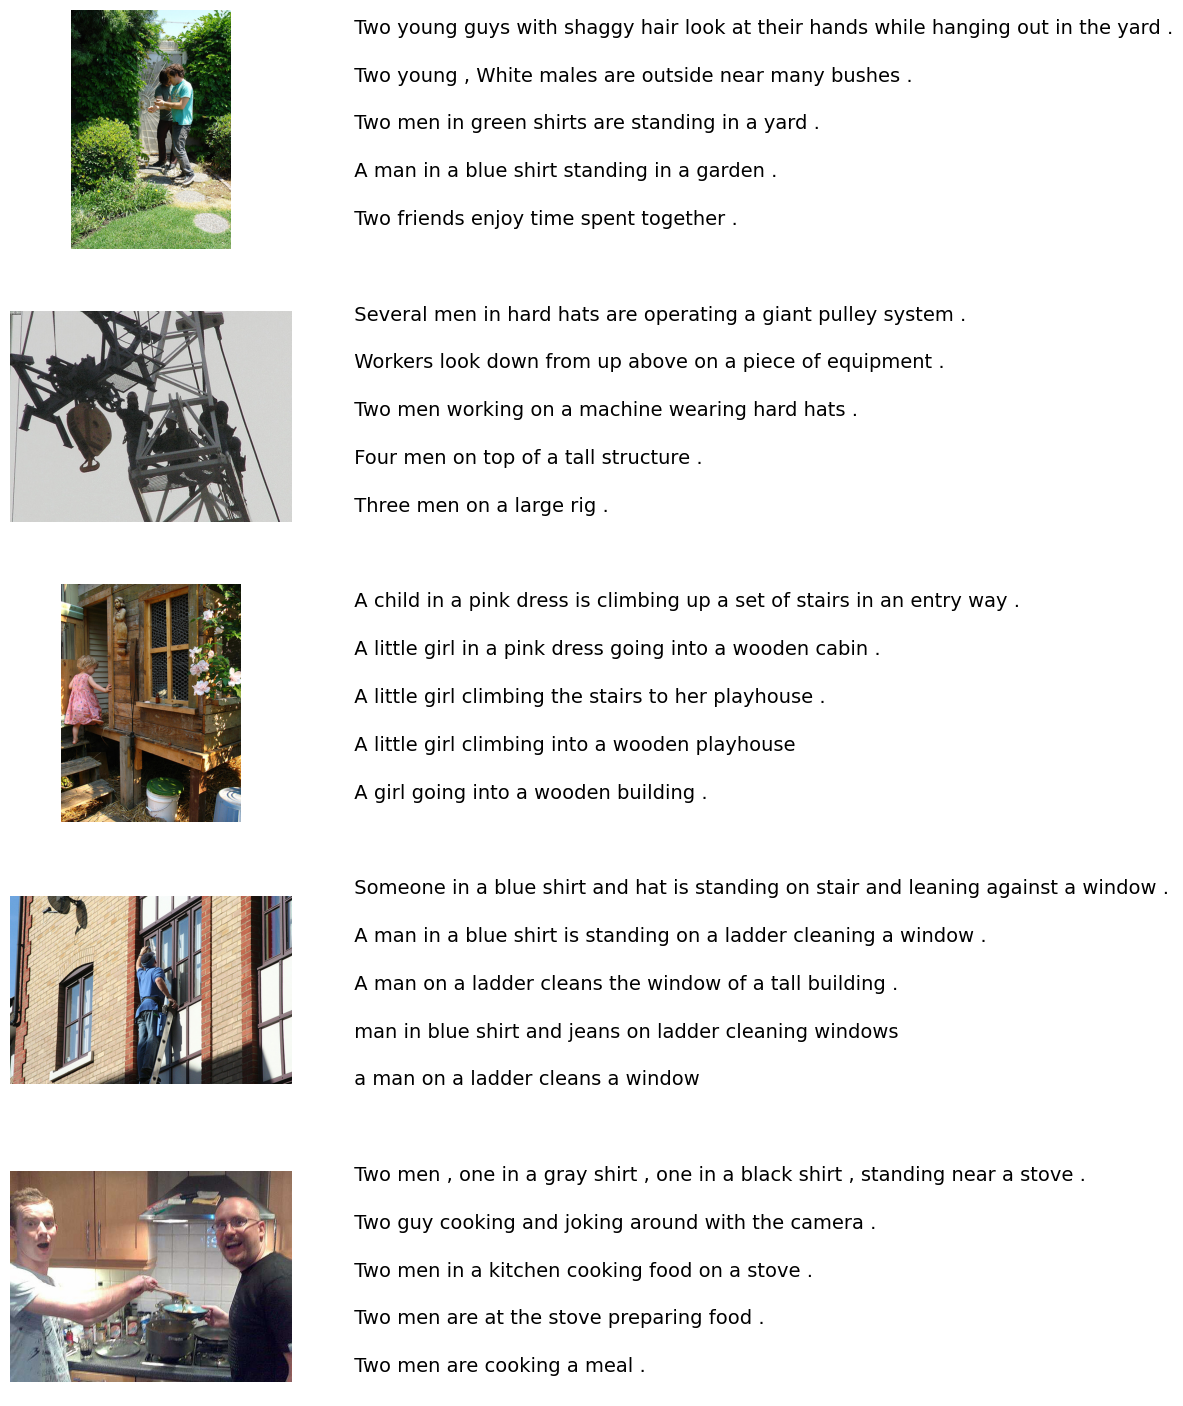

In [8]:
sample_data = df.groupby("image_path")["comment"].agg(list)

fig, axes = plt.subplots(5,2,figsize=(8,18))

for ax_row, index, sample in zip(axes, sample_data.index, sample_data):
    ax_row[0].imshow(Image.open(index))
    ax_row[0].axis("off")
    text_y = 0.9
    for cap in sample:
        ax_row[1].text(0, text_y, cap, fontsize=14)
        text_y -= 0.2
    ax_row[1].axis("off")

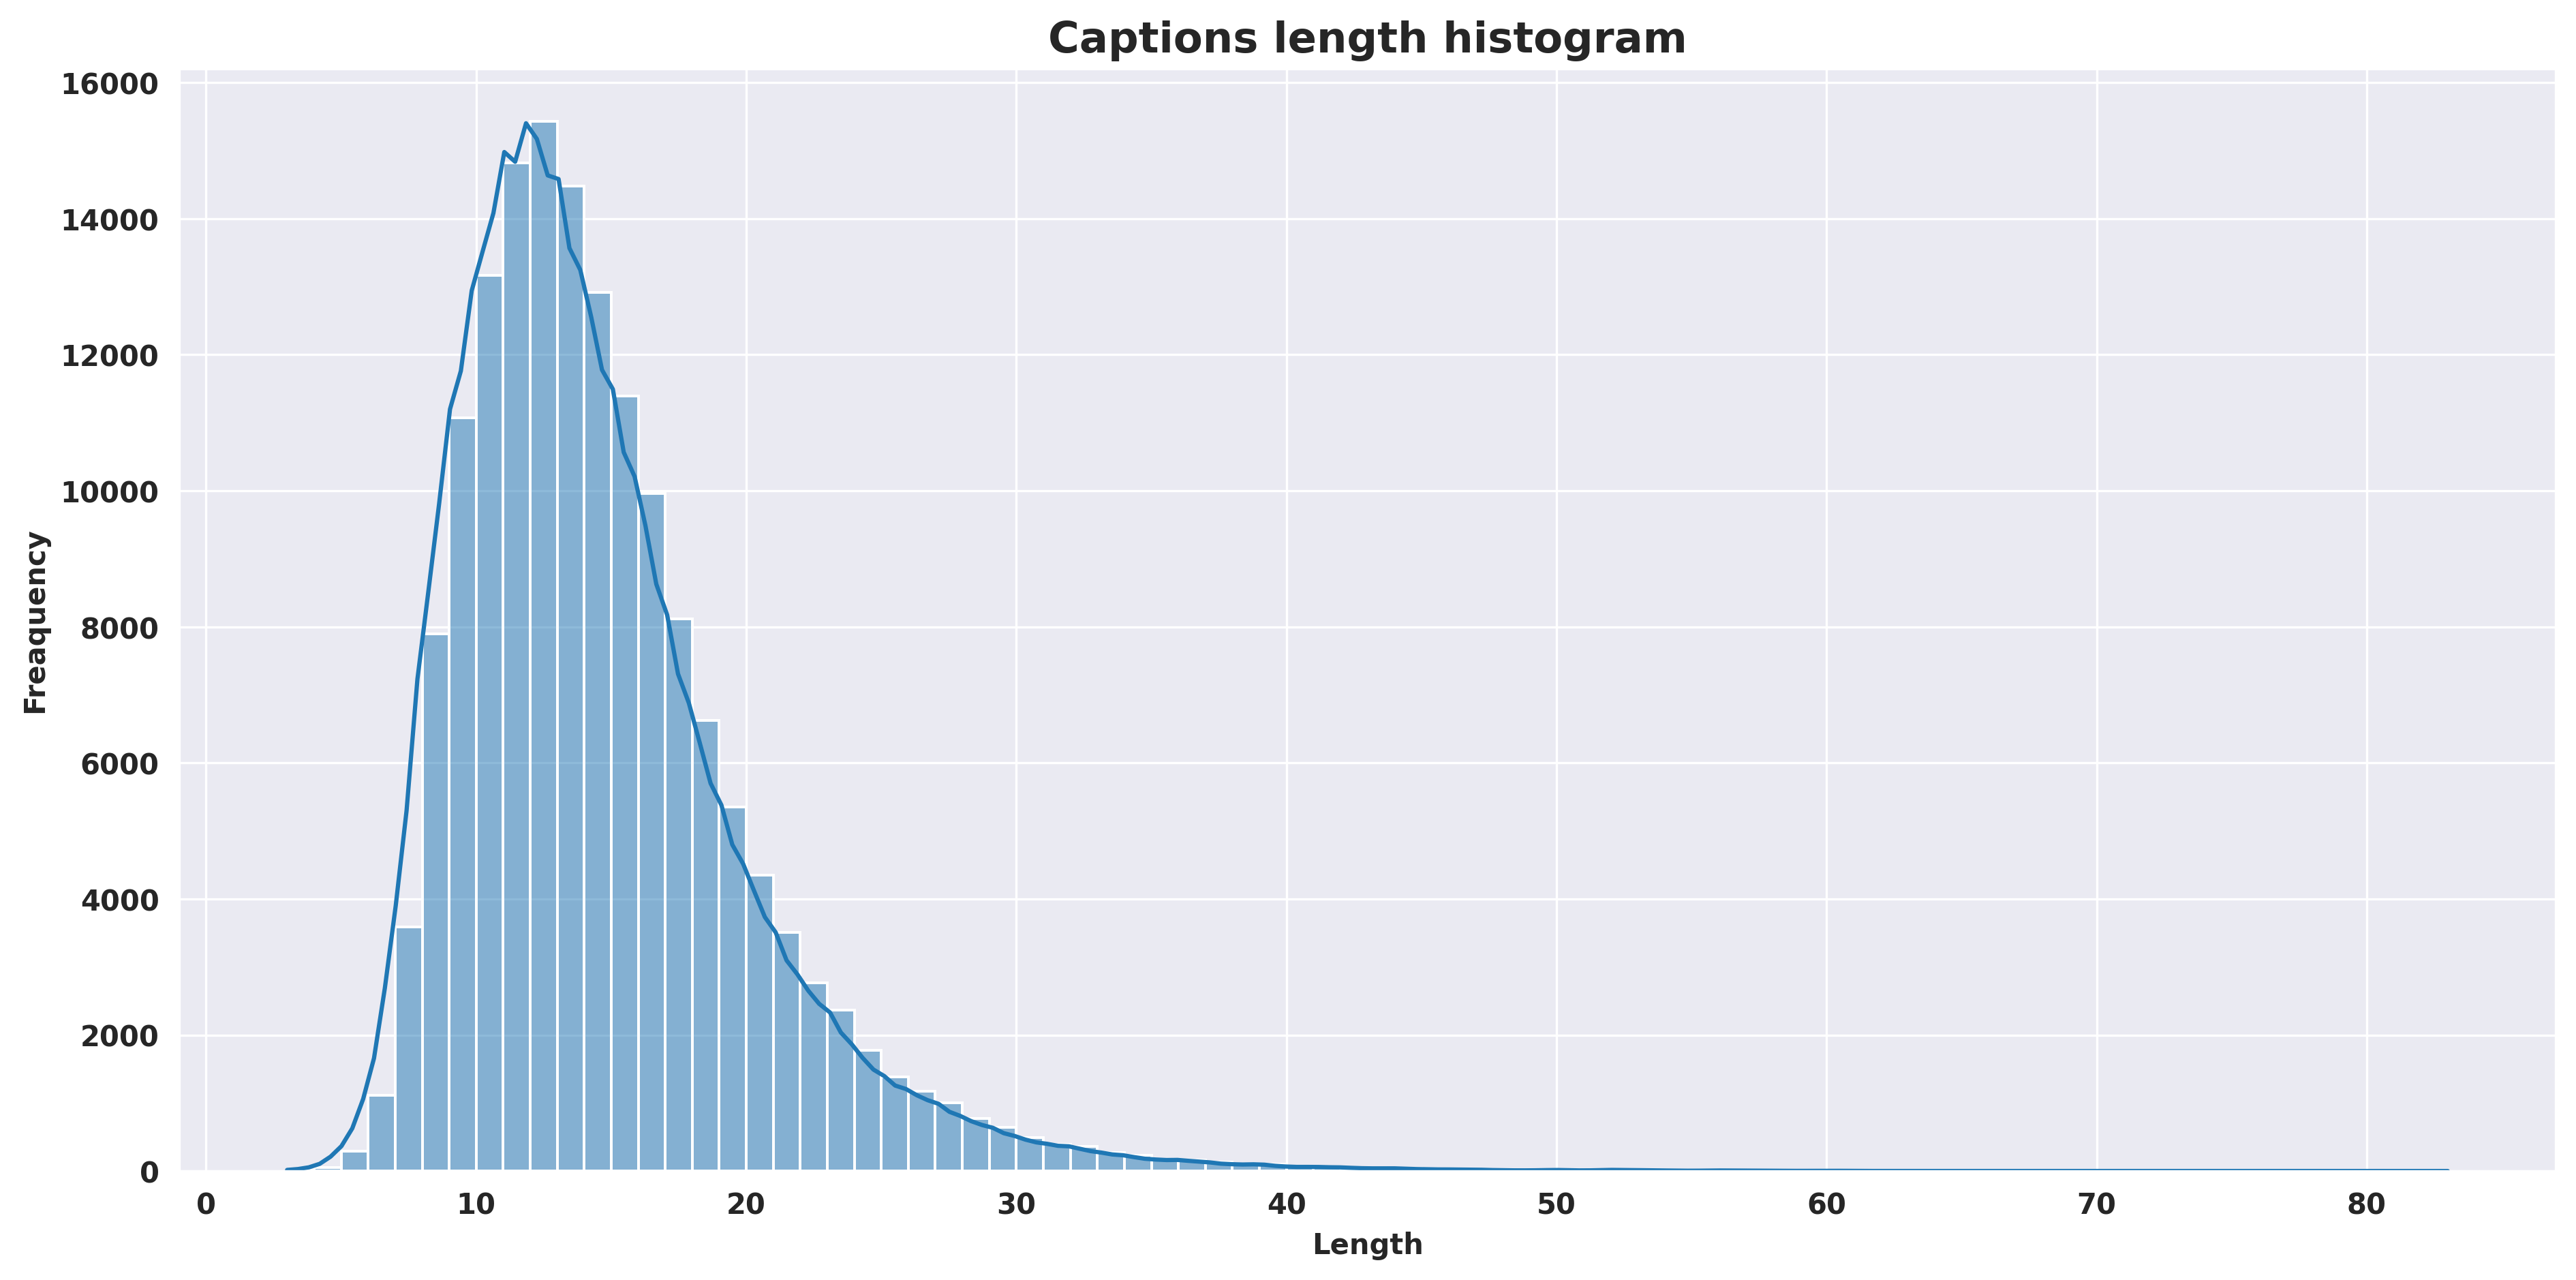

In [9]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1) 
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()
    
captions_length(df["comment"])

In [10]:
image_stats = df.loc[:1000,"image_path"].apply(lambda x: Image.open(x).size)
image_stats = pd.DataFrame(image_stats.tolist(),columns=["image_width","image_height"])
image_stats.describe()

,image_width,image_height
count,1001.000000,1001.000000
mean,458.101898,395.714286
std,65.475290,75.975880
min,320.000000,198.000000
25%,375.000000,333.000000
50%,500.000000,375.000000
75%,500.000000,500.000000
max,500.000000,500.000000


# Defining Bert Tokenizer

In [11]:
vocab_words = list(set(" ".join(df["preprocessed_comments"]).split()))
print(len(vocab_words))

20323


In [12]:
tokenizer = BertWordPieceTokenizer(
    unk_token="[UNK]",
    clean_text=False,
    lowercase=False
)

tokenizer.train_from_iterator(
    df["preprocessed_comments"].tolist(),
    vocab_size=vocab_length,
    special_tokens=["[PAD]","[UNK]","[START]","[END]"]
)

# Tokenizing sample data

In [13]:
vocab = tokenizer.get_vocab()
# Encoding a sentence
example_caption = df["preprocessed_comments"].iloc[:1]
example_tokenized_captions = tokenizer.encode_batch(example_caption)

print('caption:',example_caption[0])

for token in example_tokenized_captions[0].tokens:
    print('token:',token,"\t\tid:",vocab[token])

caption: [START]  two young guys with shaggy hair look at their hands while hanging out in the yard . [END]
token: [START] 		id: 2
token: two 		id: 172
token: young 		id: 204
token: guys 		id: 1042
token: with 		id: 146
token: shaggy 		id: 4082
token: hair 		id: 431
token: look 		id: 701
token: at 		id: 176
token: their 		id: 371
token: hands 		id: 635
token: while 		id: 218
token: hanging 		id: 1037
token: out 		id: 226
token: in 		id: 123
token: the 		id: 127
token: yard 		id: 1408
token: . 		id: 15
token: [END] 		id: 3


In [14]:
def parse_image(file_path, width, height):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.convert_image_dtype(image,tf.float32)
    image = tf.image.resize(image,[width,height])
    image = image*2.0 - 1.0
    return image

# Defining Dataset

In [15]:
def generate_tf_dataset(image_captions_df, n_vocab=5000, pad_length=33, batch_size=32, training=False):
    """ Generate the tf.data.Dataset"""
        
    # Get the caption IDs using the tokenizer
    image_captions_df["comments_token_ids"] = [enc.ids for enc in tokenizer.encode_batch(image_captions_df["preprocessed_comments"])]
    
    vocab = tokenizer.get_vocab()
    
    # Add the padding to short sentences and truncate long ones
    image_captions_df["comments_token_ids"] = image_captions_df["comments_token_ids"].apply(
        lambda x: x+[vocab["[PAD]"]]*(pad_length - len(x) + 2) if pad_length + 2 >= len(x) else x[:pad_length + 1] + [x[-1]]
    ) 
    
    # Create a dataset with images and captions
    dataset = tf.data.Dataset.from_tensor_slices({
        "image_path": image_captions_df["image_path"],
        "comments_token_ids": np.array(image_captions_df["comments_token_ids"].tolist())
    })
    
    # Each sample in our dataset consists of
    # (image, caption token IDs, position IDs), (caption token IDs offset by 1)
    dataset = dataset.map(
        lambda x: (
            (parse_image(x["image_path"], 224, 224), x["comments_token_ids"][:-1], tf.range(pad_length+1, dtype='float32')), x["comments_token_ids"]
        )
    )
    
    # Shuffle and batch data in the training mode
    if training:
        dataset = dataset.shuffle(buffer_size=batch_size*10)
    
    dataset = dataset.batch(batch_size)
    
    return dataset, tokenizer

In [16]:
batch_size=2
sample_dataset, sample_tokenizer = generate_tf_dataset(train_data, n_vocab=vocab_length, pad_length=10, batch_size=batch_size, training=True)
for i in sample_dataset.take(1):
    print(i)

((<tf.Tensor: shape=(2, 224, 224, 3), dtype=float32, numpy=
array([[[[-0.38168013, -0.20094329, -0.6048288 ],
         [-0.4023792 , -0.26482165, -0.60542214],
         [-0.53408915, -0.32374913, -0.68711245],
         ...,
         [-0.43710423, -0.26997626, -0.6286591 ],
         [-0.46417785, -0.29334694, -0.6540488 ],
         [-0.44287753, -0.2178784 , -0.6069785 ]],

        [[-0.42681444, -0.32010132, -0.6540091 ],
         [-0.48798048, -0.21370882, -0.55591357],
         [-0.39426142, -0.2447195 , -0.5860409 ],
         ...,
         [-0.48120528, -0.33621293, -0.64761543],
         [-0.53439975, -0.32389963, -0.67712724],
         [-0.56132275, -0.3431087 , -0.70186424]],

        [[-0.47696322, -0.28315574, -0.6116487 ],
         [-0.40564835, -0.30250645, -0.6287379 ],
         [-0.4446997 , -0.25476354, -0.586892  ],
         ...,
         [-0.4919665 , -0.31211978, -0.6778622 ],
         [-0.49044025, -0.40720963, -0.7146882 ],
         [-0.47042757, -0.32875222, -0.66672

# Model Creation

# Importing Vision Tranformer

In [17]:
import tensorflow_hub as hub
import tensorflow.keras.backend as K
import tf_keras

K.clear_session()

image_input = tf_keras.layers.Input(shape=(224, 224, 3))
image_encoder = hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_s16_fe/1", trainable=False)
image_features = image_encoder(image_input)
print(f"Final representation shape: {image_features.shape}")

Final representation shape: (None, 384)


# Defining Decode Layer

In [18]:

class SelfAttentionLayer(keras.layers.Layer):
    """ Defines the computations in the self attention layer """
    
    def __init__(self, d):        
        super(SelfAttentionLayer, self).__init__()
        # Feature dimensionality of the output
        self.d = d
    
    def build(self, input_shape):
        # Query weight matrix
        self.Wq = self.add_weight(
            shape=(input_shape[-1], self.d), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )        
        # Key weight matrix
        self.Wk = self.add_weight(
            shape=(input_shape[-1], self.d), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )
        # Value weight matrix
        self.Wv = self.add_weight(
            shape=(input_shape[-1], self.d), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )
    
    def call(self, q_x, k_x, v_x, mask=None):
        
        q = tf.matmul(q_x,self.Wq) #[None, t, d]
        k = tf.matmul(k_x,self.Wk) #[None, t, d]
        v = tf.matmul(v_x,self.Wv) #[None, t, d]
        
        # Computing the final output
        h = keras.layers.Attention(causal=True)([
            q, #q
            v, #v
            k, #k
        ], mask=[None, mask]) # [None, t, t] . [None, t, d] => [None, t, d]
        
        return h
    
    
class TransformerDecoderLayer(keras.layers.Layer):
    """ The Decoder layer """
    
    def __init__(self, d, n_heads):
        super(TransformerDecoderLayer, self).__init__()
        # Feature dimensionality
        self.d = d
        
        # Dimensionality of a head
        self.d_head = int(d/n_heads) 
        
        # Number of heads
        self.n_heads = n_heads
        
        # Actual attention heads
        self.attn_heads = [SelfAttentionLayer(self.d_head) for i in range(self.n_heads)]
        
        # Fully connected layers
        self.fc1_layer = keras.layers.Dense(512, activation='relu')
        self.fc2_layer = keras.layers.Dense(d)
        
        self.add_layer = keras.layers.Add()
        self.norm1_layer = keras.layers.LayerNormalization()
        self.norm2_layer = keras.layers.LayerNormalization()
        
    
    def _compute_multihead_output(self, x):
        """ Computing the multi head attention output"""
        outputs = [head(x, x, x) for head in self.attn_heads]            
        outputs = tf.concat(outputs, axis=-1)
        return outputs
        
    def call(self, x):
        
        
        # Multi head attention layer output
        h1 = self._compute_multihead_output(x)
        
        h1_add = self.add_layer([x, h1])
        h1_norm = self.norm1_layer(h1_add)
        
        # Fully connected outputs
        h2_1 = self.fc1_layer(h1_norm)
        h2_2 = self.fc2_layer(h2_1)
        
        h2_add = self.add_layer([h1, h2_2])
        h2_norm = self.norm2_layer(h2_add)
        
        
        return h2_norm
    

# Input layer
caption_input = keras.layers.Input(shape=(None,))
position_input = keras.layers.Input(shape=(None,))
d_model = 384

# Token embeddings
input_embedding = keras.layers.Embedding(len(tokenizer.get_vocab()), d_model, mask_zero=True)

# Position embeddings
position_embedding = keras.layers.Lambda(
    lambda x: tf.where(
        tf.math.mod(tf.repeat(tf.expand_dims(x, axis=-1), d_model, axis=-1), 2)==0,
        tf.math.sin(
            #tf.repeat(tf.expand_dims(x, axis=-1), d_model, axis=-1) /
            tf.expand_dims(x, axis=-1) /
            10000**(2*tf.reshape(tf.range(d_model, dtype='float32'),[1,1, -1])/d_model)
        ),
        tf.math.cos(
            tf.expand_dims(x, axis=-1) /
            10000**(2*tf.reshape(tf.range(d_model, dtype='float32'),[1,1, -1])/d_model)
        )
    )
)

# Combined token position embeddings
embed_out = input_embedding(caption_input) + position_embedding(position_input)
print(tf.expand_dims(image_features,axis=1).shape)
# Concatenate image caption and token embeddings
image_caption_embed_out = keras.layers.Concatenate(axis=1)([tf.expand_dims(image_features,axis=1), embed_out])

# Generate hidden representation with Transformer decoder layer
out = image_caption_embed_out
for l in range(4):
    out  = TransformerDecoderLayer(d_model, 64)(out)

# Final prediction layer
final_out = keras.layers.Dense(vocab_length, activation='softmax')(out)

# Define the final model and compile
full_model = keras.models.Model(inputs=[image_input, caption_input, position_input], outputs=final_out)
full_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')

full_model.summary()

(None, 1, 384)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 keras_layer (KerasLayer)    (None, 384)                  2166566   ['input_1[0][0]']             
                                                          4                    

# Defining BLEU score metrics

In [19]:
import collections
import math


def _get_ngrams(segment, max_order):
    """Extracts all n-grams upto a given maximum order from an input segment.

      Args:
        segment: text segment from which n-grams will be extracted.
        max_order: maximum length in tokens of the n-grams returned by this
            methods.

      Returns:
        The Counter containing all n-grams upto max_order in segment
        with a count of how many times each n-gram occurred.
    """
    ngram_counts = collections.Counter()
    for order in range(1, max_order + 1):
        for i in range(0, len(segment) - order + 1):
            ngram = tuple(segment[i:i+order])
            ngram_counts[ngram] += 1
    return ngram_counts


def compute_bleu(reference_corpus, translation_corpus, max_order=4,
                 smooth=False):
    """Computes BLEU score of translated segments against one or more references.

      Args:
        reference_corpus: list of lists of references for each translation. Each
            reference should be tokenized into a list of tokens.
        translation_corpus: list of translations to score. Each translation
            should be tokenized into a list of tokens.
        max_order: Maximum n-gram order to use when computing BLEU score.
        smooth: Whether or not to apply Lin et al. 2004 smoothing.

      Returns:
        3-Tuple with the BLEU score, n-gram precisions, geometric mean of n-gram
        precisions and brevity penalty.
    """
    matches_by_order = [0] * max_order
    possible_matches_by_order = [0] * max_order
    reference_length = 0
    translation_length = 0
    for (references, translation) in zip(reference_corpus,
                                           translation_corpus):
        reference_length += min(len(r) for r in references)
        translation_length += len(translation)

        merged_ref_ngram_counts = collections.Counter()
        for reference in references:
            merged_ref_ngram_counts |= _get_ngrams(reference, max_order)
        translation_ngram_counts = _get_ngrams(translation, max_order)
        overlap = translation_ngram_counts & merged_ref_ngram_counts
        for ngram in overlap:
            matches_by_order[len(ngram)-1] += overlap[ngram]
        for order in range(1, max_order+1):
            possible_matches = len(translation) - order + 1
            if possible_matches > 0:
                possible_matches_by_order[order-1] += possible_matches

        precisions = [0] * max_order
        for i in range(0, max_order):
            if smooth:
                   precisions[i] = ((matches_by_order[i] + 1.) /
                           (possible_matches_by_order[i] + 1.))
            else:
                if possible_matches_by_order[i] > 0:
                    precisions[i] = (float(matches_by_order[i]) /
                             possible_matches_by_order[i])
                else:
                    precisions[i] = 0.0

        if min(precisions) > 0:
            p_log_sum = sum((1. / max_order) * math.log(p) for p in precisions)
            geo_mean = math.exp(p_log_sum)
        else:
            geo_mean = 0

        ratio = float(translation_length) / reference_length

        if ratio > 1.0:
            bp = 1.
        else:
            bp = math.exp(1 - 1. / ratio)

        bleu = geo_mean * bp

        return (bleu, precisions, bp, ratio, translation_length, reference_length)


In [20]:

class BLEUMetric(object):
    
    def __init__(self, tokenizer, name='bleu_metric', **kwargs):
        """ Computes the BLEU score (Metric for machine translation) """
        super().__init__()
        self.tokenizer = tokenizer
    
      #self.vocab = vocabulary
      #self.id_to_token_layer = StringLookup(vocabulary=self.vocab, num_oov_indices=0, oov_token='[UNKUNK]', invert=True)
    
    def calculate_bleu_from_predictions(self, real, pred):
        """ Calculate the BLEU score for targets and predictions """
        
        # Get the predicted token IDs
        pred_argmax = tf.argmax(pred, axis=-1)  
        
        # Convert token IDs to words using the vocabulary and the StringLookup
        pred_tokens = np.array([[self.tokenizer.id_to_token(pp) for pp in p] for p in pred_argmax])
        real_tokens = tf.constant([[self.tokenizer.id_to_token(rr) for rr in r] for r in real])
        
        def clean_text(tokens):
            
            """ Clean padding and other tokens to only keep meaningful words """
            
            # 3. Strip the string of any extra white spaces
            translations_in_bytes = tf.strings.strip(
                        # 2. Replace everything after the eos token with blank
                        tf.strings.regex_replace(
                            # 1. Join all the tokens to one string in each sequence
                            tf.strings.join(
                                tf.transpose(tokens), separator=' '
                            ),
                        "\[END\].*", ""),
                   )
            
            # Decode the byte stream to a string
            translations = np.char.decode( #
                translations_in_bytes.numpy().astype(np.bytes_), encoding='utf-8'
            )
            
            # If the string is empty, add a [UNK] token
            # Otherwise get a Division by zero error
            translations = [sent if len(sent)>0 else "[UNK]" for sent in translations ]
            
            # Split the sequences to individual tokens 
            translations = np.char.split(translations).tolist()
            
            return translations
        
        # Get the clean versions of the predictions and real seuqences
        pred_tokens = clean_text(pred_tokens)
        # We have to wrap each real sequence in a list to make use of a function to compute bleu
        real_tokens = [[token_seq] for token_seq in clean_text(real_tokens)]

        # The compute_bleu method accpets the translations and references in the following format
        # tranlation - list of list of tokens
        # references - list of list of list of tokens
        bleu, precisions, bp, ratio, translation_length, reference_length = compute_bleu(real_tokens, pred_tokens, smooth=False)

        return bleu

# Training the model

In [21]:
batch_size=96

bleu_metric = BLEUMetric(tokenizer=tokenizer)


for e in range(5):
    print(f"Epoch: {e+1}")
    
    train_dataset, _ = generate_tf_dataset(
        train_data, n_vocab=vocab_length, batch_size=batch_size, training=True
    )
    valid_dataset, _ = generate_tf_dataset(
        validation_data, n_vocab=vocab_length, batch_size=batch_size, training=False
    )
    
    full_model.fit(
        train_dataset,
        epochs=1
    )
    
    valid_loss, valid_accuracy, valid_bleu = [], [], []
    for vi, v_batch in enumerate(valid_dataset):
        print(f"{vi+1} batches processed", end='\r')
        loss, accuracy = full_model.test_on_batch(v_batch[0], v_batch[1])
        batch_predicted = full_model(v_batch[0])
        bleu_score = bleu_metric.calculate_bleu_from_predictions(v_batch[1], batch_predicted)
        valid_loss.append(loss)
        valid_accuracy.append(accuracy)
        valid_bleu.append(bleu_score)
        
    print(
        f"\nvalid_loss: {np.mean(valid_loss)} - valid_accuracy: {np.mean(valid_accuracy)} - valid_bleu: {np.mean(valid_bleu)}"
    )

Epoch: 1


I0000 00:00:1732735732.742658     216 service.cc:145] XLA service 0x7ee93c0059a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732735732.742728     216 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732735732.742735     216 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732735739.014534     216 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1490/1490 [==============================] - 1413s 790ms/step - loss: 1.8942 - accuracy: 0.6899
83 batches processed
valid_loss: 1.5011789770011443 - valid_accuracy: 0.7232163225311831 - valid_bleu: 0.00876583016320535
Epoch: 2
1490/1490 [==============================] - 1175s 788ms/step - loss: 1.4400 - accuracy: 0.7276
83 batches processed
valid_loss: 1.4108095427593552 - valid_accuracy: 0.7317537550466606 - valid_bleu: 0.02914999254209936
Epoch: 3
1490/1490 [==============================] - 1176s 788ms/step - loss: 1.3548 - accuracy: 0.7334
83 batches processed
valid_loss: 1.37066840838237 - valid_accuracy: 0.736251278814063 - valid_bleu: 0.037585050836480685
Epoch: 4
1490/1490 [==============================] - 1172s 786ms/step - loss: 1.3237 - accuracy: 0.7345
83 batches processed
valid_loss: 1.3862253370055233 - valid_accuracy: 0.7336017805409719 - valid_bleu: 0.030143733865849724
Epoch: 5
1490/1490 [==============================] - 1175s 787ms/step - loss: 1.2688 - accuracy: 

# Analysing test data

In [22]:
bleu_metric = BLEUMetric(tokenizer=tokenizer)

test_dataset, _ = generate_tf_dataset(
    test_data,  n_vocab=vocab_length, batch_size=batch_size, training=False
)

test_loss, test_accuracy, test_bleu = [], [], []
for ti, t_batch in enumerate(test_dataset):
    print(f"{ti+1} batches processed", end='\r')
    loss, accuracy = full_model.test_on_batch(t_batch[0], t_batch[1])
    batch_predicted = full_model.predict_on_batch(t_batch[0])
    bleu_score = bleu_metric.calculate_bleu_from_predictions(t_batch[1], batch_predicted)
    test_loss.append(loss)
    test_accuracy.append(accuracy)
    test_bleu.append(bleu_score)

print(
    f"\ntest_loss: {np.mean(test_loss)} - test_accuracy: {np.mean(test_accuracy)} - test_bleu: {np.mean(test_bleu)}"
)

83 batches processed
test_loss: 1.3462962271219276 - test_accuracy: 0.7402733542832983 - test_bleu: 0.052086850127596916


# Generating Sample Captions

I0000 00:00:1732744535.329391    7698 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_109', 2144 bytes spill stores, 2144 bytes spill loads



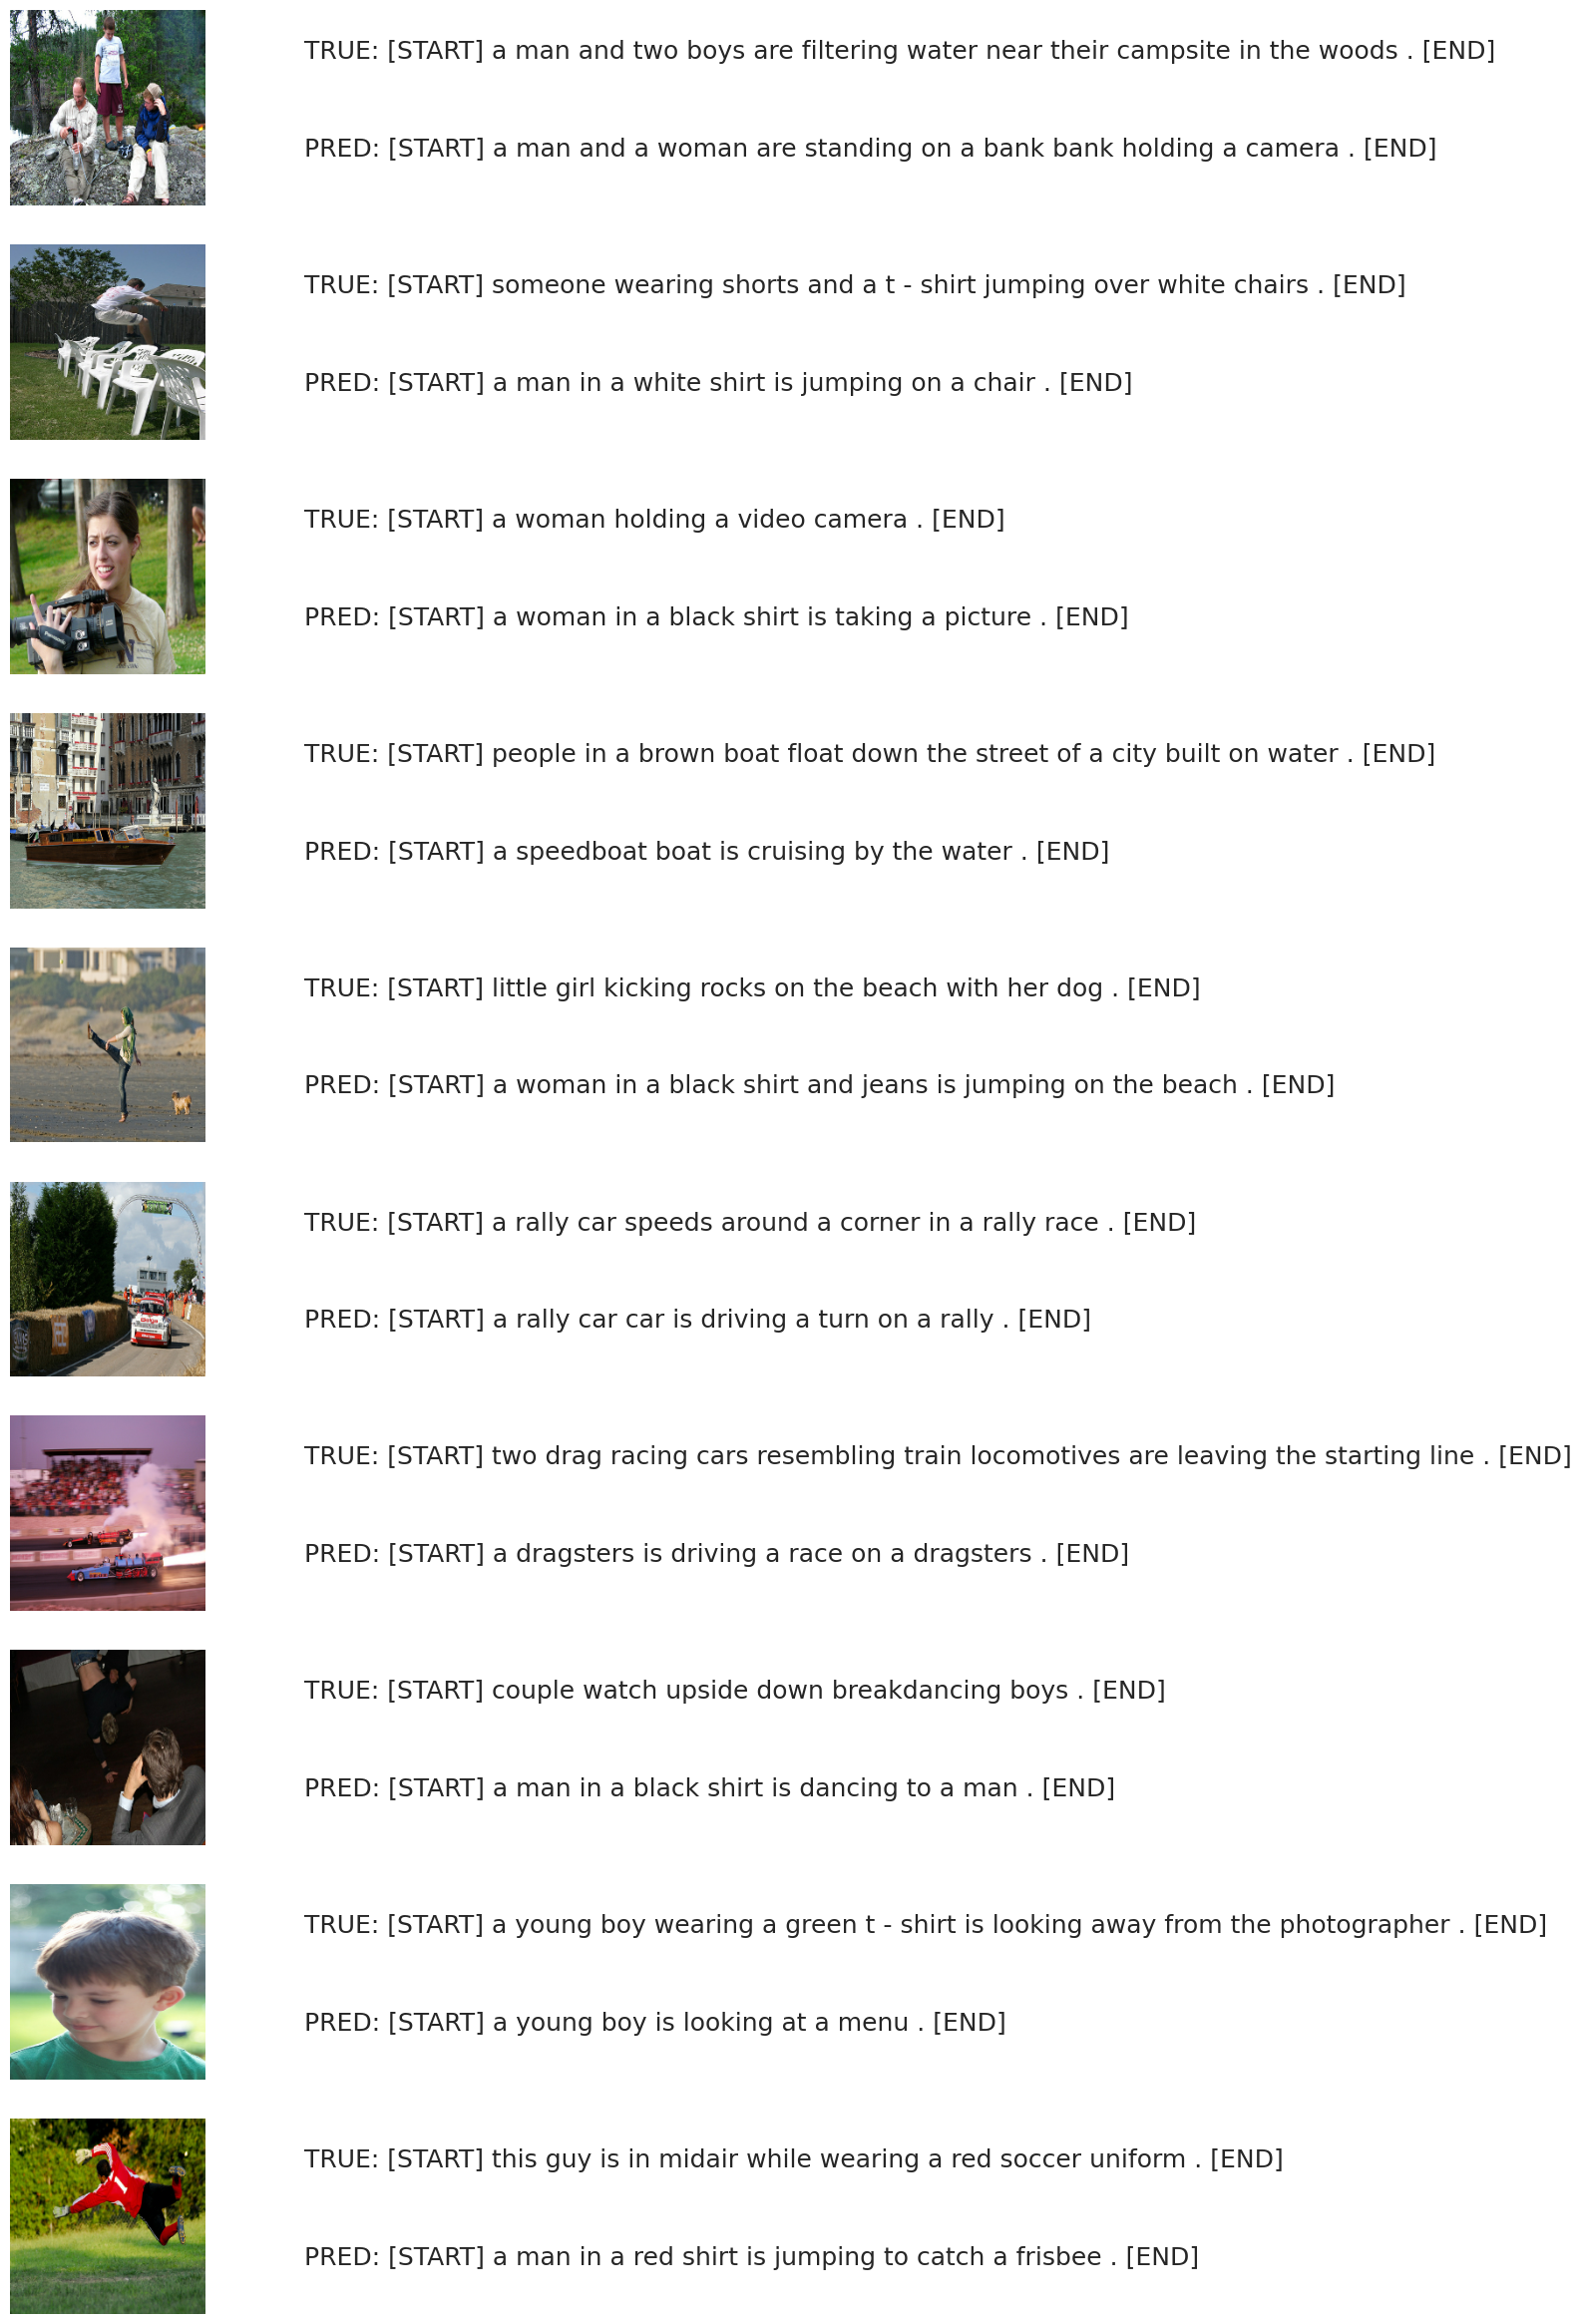

In [23]:
n_samples = 10
test_dataset, _ = generate_tf_dataset(
    test_data.sample(n=n_samples), n_vocab=vocab_length, batch_size=n_samples, training=False
)

def generate_caption(model, image_input, tokenizer, n_samples):
    # 2 -> [START]
    batch_tokens = np.repeat(np.array([[2]]), n_samples, axis=0)
    
    for i in range(30):
        if np.all(batch_tokens[:,-1] == 3):
            break
            
        position_input = tf.repeat(tf.reshape(tf.range(i+1),[1,-1]), n_samples, axis=0)
        probs = full_model((image_input, batch_tokens, position_input)).numpy()
        batch_tokens = np.argmax(probs, axis=-1)
    
    predicted_text = []
    for sample_tokens in batch_tokens:
        sample_predicted_token_ids = sample_tokens.ravel()
        sample_predicted_tokens = []
        for wid in sample_predicted_token_ids:
            sample_predicted_tokens.append(tokenizer.id_to_token(wid))
            if wid == 3:
                break
        sample_predicted_text = " ".join([tok for tok in sample_predicted_tokens])
        sample_predicted_text = sample_predicted_text.replace(" ##", "")
        predicted_text.append(sample_predicted_text)
    
    return predicted_text
    
    
for batch in test_dataset.take(1):
    (batch_image_input, _, _), batch_true_caption = batch

batch_predicted_text = generate_caption(full_model, batch_image_input, tokenizer, n_samples)

fig, axes = plt.subplots(n_samples, 2, figsize=(8,30))

for i,(sample_image_input, sample_true_caption, sample_predicated_caption) in enumerate(zip(batch_image_input, batch_true_caption, batch_predicted_text)):
    
    sample_true_caption_tokens  = [tokenizer.id_to_token(wid) for wid in sample_true_caption.numpy().ravel()]
    
    sample_true_text = []
    for tok in sample_true_caption_tokens:
        sample_true_text.append(tok)
        if tok == '[END]':
            break
    
    sample_true_text = " ".join(sample_true_text).replace(" ##", "")
    axes[i][0].imshow(((sample_image_input.numpy()+1.0)/2.0))
    axes[i][0].axis('off')
    
    true_annotation = f"TRUE: {sample_true_text}"
    predicted_annotation = f"PRED: {sample_predicated_caption}"
    axes[i][1].text(0, 0.75, true_annotation, fontsize=18)
    axes[i][1].text(0, 0.25, predicted_annotation, fontsize=18)
    axes[i][1].axis('off')


